# Interpretation

Code that uses LIME for interpretation of the agent used for the previous observations obtained

Import the neccesary libraries

In [1]:
import tensorflow as tf
slim = tf.contrib.slim
import sys
#sys.path.append('/Users/marcotcr/phd/tf-models/slim')
sys.path.append('/home/mlvm2/tf-models/slim')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from nets import inception
from preprocessing import inception_preprocessing
from datasets import imagenet
import os
from lime import lime_image
import time
from skimage.segmentation import mark_boundaries

import numpy as np
import uuid
import argparse

import cv2
import six
from six.moves import queue


from tensorpack import *
from tensorpack.utils.concurrency import ensure_proc_terminate, start_proc_mask_signal
from tensorpack.utils.serialize import dumps
from tensorpack.tfutils import symbolic_functions as symbf
from tensorpack.tfutils.gradproc import MapGradient, SummaryGradient
from tensorpack.utils.gpu import get_nr_gpu

# LIME

Download the neccesary libraries for LIME and the agent

In [2]:
from PIL import Image
from numpy import array
import gym
from simulator import SimulatorProcess, SimulatorMaster, TransitionExperience
from common import Evaluator, eval_model_multithread, play_n_episodes
from atari_wrapper import MapState, FrameStack, FireResetEnv, LimitLength

In [3]:
from train_atari import *

Read the image and load its profile

In [4]:
game ="Breakout-v0"

In [5]:
img = Image.open(game+"-0-9.png")
arr = array(img)

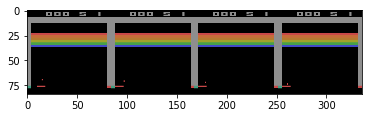

In [6]:
plt.imshow(img)

In [7]:
pred = main2(game)

[0421 16:41:21 @train_atari.py:279] Environment Name: Breakout-v0


[2018-04-21 16:41:21,317] Making new env: Breakout-v0


[0421 16:41:21 @train_atari.py:281] Number of actions: 4
[0421 16:41:21 @registry.py:122] conv0 input: [None, 84, 84, 12]
[0421 16:41:21 @registry.py:130] conv0 output: [None, 84, 84, 32]
[0421 16:41:21 @registry.py:122] pool0 input: [None, 84, 84, 32]
[0421 16:41:21 @registry.py:130] pool0 output: [None, 42, 42, 32]
[0421 16:41:21 @registry.py:122] conv1 input: [None, 42, 42, 32]
[0421 16:41:21 @registry.py:130] conv1 output: [None, 42, 42, 32]
[0421 16:41:21 @registry.py:122] pool1 input: [None, 42, 42, 32]
[0421 16:41:21 @registry.py:130] pool1 output: [None, 21, 21, 32]
[0421 16:41:21 @registry.py:122] conv2 input: [None, 21, 21, 32]
[0421 16:41:21 @registry.py:130] conv2 output: [None, 21, 21, 64]
[0421 16:41:21 @registry.py:122] pool2 input: [None, 21, 21, 64]
[0421 16:41:21 @registry.py:130] pool2 output: [None, 10, 10, 64]
[0421 16:41:21 @registry.py:122] conv3 input: [None, 10, 10, 64]
[0421 16:41:21 @registry.py:130] conv3 output: [None, 10, 10, 64]
[0421 16:41:21 @registry.p

Stablish the number of samples for lime

In [8]:
numberTimes = 10

Function that converts image into an array suitable for the predictor

In [9]:
def grow(s,sizeFirst):
    
    stacker = np.zeros((84, 84, 12), dtype="uint8")
    
    ni = 0
    while ni <84:
        nj = 0
        while nj < 84:
            nk = 0
            while nk < sizeFirst:
                stacker[ni][nj][0]=s[nk][ni][nj][0]
                stacker[ni][nj][1]=s[nk][ni][nj][1]
                stacker[ni][nj][2]=s[nk][ni][nj][2]

                stacker[ni][nj][3]=s[nk][ni][84+nj][0]
                stacker[ni][nj][4]=s[nk][ni][84+nj][1]
                stacker[ni][nj][5]=s[nk][ni][84+nj][2]

                stacker[ni][nj][6]=s[nk][ni][168+nj][0]
                stacker[ni][nj][7]=s[nk][ni][168+nj][1]
                stacker[ni][nj][8]=s[nk][ni][168+nj][2]

                stacker[ni][nj][9]=s[nk][ni][252+nj][0]
                stacker[ni][nj][10]=s[nk][ni][252+nj][1]
                stacker[ni][nj][11]=s[nk][ni][252+nj][2]
                nk += 1
            nj +=1
        ni+=1
    return stacker

Function present in atary_play.py, which gives the action that the agent must do according to its situation

In [10]:
def predict2(s):
        """
        Map from observation to action, with 0.001 greedy.
        """
        sizeFirst, a,b,c = s.shape
        new_act = np.zeros((numberTimes, numberTimes), dtype="float32")
        s = grow(s, sizeFirst)
        i = 0
        while i < numberTimes: 
            act = pred(s[None, :, :,:])[0][0].argmax()
            new_act[0][i]=act
            i +=1
        print (new_act.shape)
        return new_act

Obtain the explainer and the explanations

In [11]:
explainer = lime_image.LimeImageExplainer()

In [12]:
explanation = explainer.explain_instance(arr, predict2,num_samples=numberTimes)

(10, 10)


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.995676640495181e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Show some explanations

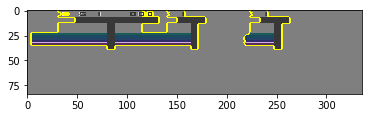

In [13]:
temp, mask = explanation.get_image_and_mask(5, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))